# Example `Dysmalpy` 1D fitting

**Includes the following components:**
 - Disk + Bulge
 - NFW halo
 - Constant velocity dispersion

## Setup

In [4]:
# Import modules
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from dysmalpy import galaxy
from dysmalpy import models
from dysmalpy import fitting
from dysmalpy import instrument
from dysmalpy import data_classes
from dysmalpy import parameters
from dysmalpy import plotting
from dysmalpy import aperture_classes

import os
import copy

import numpy as np
import astropy.units as u
import astropy.io.fits as fits

In [5]:
# A check for compatibility:
import emcee
if np.int(emcee.__version__[0]) >= 3:
    ftype_sampler = 'h5'
else:
    ftype_sampler = 'pickle' 

##### Setup notebook #####

In [6]:
# Jupyter notebook setup
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import Image

In [7]:
import logging
logger = logging.getLogger('DysmalPy')
logger.setLevel(logging.INFO)

## Set data, output paths

In [8]:
# Data directory
data_dir = '/Users/sedona/data/dysmalpy_example_data/'
#'/YOUR/DATA/PATH/'

# Where to save output files
#outdir  = './output_1D/'
outdir = '/Users/sedona/data/dysmalpy_test_examples/JUPYTER_OUTPUT_1D/'

-------------------

## Define functions to tie parameters together

In [9]:
# Tie the z height to the effective radius
def tie_sigz_reff(model_set):
 
    reff = model_set.components['disk+bulge'].r_eff_disk.value
    invq = model_set.components['disk+bulge'].invq_disk
    sigz = 2.0*reff/invq/2.35482

    return sigz

In [10]:
# Tie the halo mass to the dark matter fraction
def tie_lmvirial_NFW(model_set):
    comp_halo = model_set.components.__getitem__('halo')
    comp_baryons = model_set.components.__getitem__('disk+bulge')
    r_fdm = model_set.components['disk+bulge'].r_eff_disk.value
    mvirial = comp_halo.calc_mvirial_from_fdm(comp_baryons, r_fdm, 
                    adiabatic_contract=model_set.kinematic_options.adiabatic_contract)
    return mvirial

----------

## Initialize galaxy, model set, instrument

In [11]:
gal = galaxy.Galaxy(z=1.613, name='GS4_43501')
mod_set = models.ModelSet()
inst = instrument.Instrument()

### Baryonic component: Combined Disk+Bulge

In [12]:
total_mass = 11.0    # M_sun
bt = 0.3             # Bulge-Total ratio
r_eff_disk = 5.0     # kpc
n_disk = 1.0
invq_disk = 5.0
r_eff_bulge = 1.0    # kpc
n_bulge = 4.0
invq_bulge = 1.0
noord_flat = True    # Switch for applying Noordermeer flattening

# Fix components
bary_fixed = {'total_mass': False,
              'r_eff_disk': False, #True,
              'n_disk': True,
              'r_eff_bulge': True,
              'n_bulge': True,
              'bt': True}

# Set bounds
bary_bounds = {'total_mass': (10, 13),
               'r_eff_disk': (1.0, 30.0),
               'n_disk': (1, 8),
               'r_eff_bulge': (1, 5),
               'n_bulge': (1, 8),
               'bt': (0, 1)}

bary = models.DiskBulge(total_mass=total_mass, bt=bt,
                        r_eff_disk=r_eff_disk, n_disk=n_disk,
                        invq_disk=invq_disk,
                        r_eff_bulge=r_eff_bulge, n_bulge=n_bulge,
                        invq_bulge=invq_bulge,
                        noord_flat=noord_flat,
                        name='disk+bulge',
                        fixed=bary_fixed, bounds=bary_bounds)

bary.r_eff_disk.prior = parameters.BoundedGaussianPrior(center=5.0, stddev=1.0)

### Halo component

In [13]:
mvirial = 12.0
conc = 5.0
fdm = 0.5

halo_fixed = {'mvirial': False,
              'conc': True, 
              'fdm':  False}
# Mvirial will be tied -- so must set 'fixed=False' for Mvirial...

halo_bounds = {'mvirial': (10, 13),
               'conc': (1, 20),
               'fdm': (0, 1)}

halo = models.NFW(mvirial=mvirial, conc=conc, fdm=fdm, z=gal.z,
                  fixed=halo_fixed, bounds=halo_bounds, name='halo')


halo.mvirial.tied = tie_lmvirial_NFW

### Dispersion profile

In [14]:
sigma0 = 39.   # km/s
disp_fixed = {'sigma0': False}
disp_bounds = {'sigma0': (5, 300)}

disp_prof = models.DispersionConst(sigma0=sigma0, fixed=disp_fixed,
                                          bounds=disp_bounds, name='dispprof')

### z-height profile

In [15]:
sigmaz = 0.9   # kpc
zheight_fixed = {'sigmaz': False}

zheight_prof = models.ZHeightGauss(sigmaz=sigmaz, name='zheightgaus',
                                   fixed=zheight_fixed)
zheight_prof.sigmaz.tied = tie_sigz_reff

### Geometry

In [16]:
inc = 62.     # degrees
pa = 142.     # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center

geom_fixed = {'inc': True,
              'pa': True,
              'xshift': True,
              'yshift': True}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (0, 4),
               'yshift': (-10, -4)}

geom = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                       fixed=geom_fixed, bounds=geom_bounds, name='geom')

## Add all model components to ModelSet

In [17]:
# Add all of the model components to the ModelSet
mod_set.add_component(bary, light=True)
mod_set.add_component(halo)
mod_set.add_component(disp_prof)
mod_set.add_component(zheight_prof)
mod_set.add_component(geom)

### Set kinematic options for calculating velocity profile

In [18]:
mod_set.kinematic_options.adiabatic_contract = False
mod_set.kinematic_options.pressure_support = True

### Set up the instrument

In [19]:
beamsize = 0.55*u.arcsec                 # FWHM of beam
sig_inst = 45*u.km/u.s                   # Instrumental spectral resolution

beam = instrument.GaussianBeam(major=beamsize)
lsf = instrument.LSF(sig_inst)

inst.beam = beam
inst.lsf = lsf
inst.pixscale = 0.125*u.arcsec           # arcsec/pixel
inst.fov = [33, 33]                      # (nx, ny) pixels
inst.spec_type = 'velocity'              # 'velocity' or 'wavelength'
inst.spec_step = 10*u.km/u.s             # Spectral step
inst.spec_start = -1000*u.km/u.s         # Starting value of spectrum
inst.nspec = 201                         # Number of spectral pixels

# Set the beam kernel so it doesn't have to be calculated every step
inst.set_beam_kernel()
inst.set_lsf_kernel()

## Add the model set, instrument to the Galaxy

In [20]:
gal.model = mod_set
gal.instrument = inst

## Load data

* Load the data from file:
  - *1D velocity, dispersion profiles and error*
  - *A mask can be loaded / created as well*
  
* Put data in `Data1D` class

* Add data to Galaxy object

In [21]:
f_data_1d = data_dir+'GS4_43501.obs_prof.txt'
dat_arr = np.loadtxt(f_data_1d)
gs4_r = dat_arr[:,0]
gs4_vel = dat_arr[:,1]
gs4_disp = dat_arr[:,3]
err_vel = dat_arr[:,2]
err_disp = dat_arr[:,4]
inst_corr = True                  # Flag for if the measured dispersion has been
                                  # corrected for instrumental resolution
    
# Put data in Data1D data class: 
#    ** specifies slit width, slit PA as well **
data1d = data_classes.Data1D(r=gs4_r, velocity=gs4_vel,
                                  vel_disp=gs4_disp, vel_err=err_vel,
                                  vel_disp_err=err_disp, slit_width=beamsize.value,
                                  slit_pa=pa, inst_corr=inst_corr, 
                                  filename_velocity=f_data_1d)

# Add data to Galaxy object:
gal.data = data1d

### Setup apertures:

In [22]:
# Setup apertures: circular apertures placed on the cube for GS4_43501.

profile1d_type = 'circ_ap_cube'    # Extraction in circular apertures placed on the cube

aperture_radius = 0.5 * gal.instrument.beam.major.value

moment_calc  = False    # 1D data was extracted using Gaussian fits

gal.data.apertures = aperture_classes.setup_aperture_types(gal=gal, 
                profile1d_type=profile1d_type, 
                aperture_radius=aperture_radius, 
                from_data=True, 
                partial_weight=True,
                moment=moment_calc)

# Add profile1d_type to data:
gal.data.profile1d_type = profile1d_type

-----------------

## MPFIT Fitting

### MPFIT fitting parameters:

In [35]:
# Options passed to MPFIT:
maxiter = 200

# Other options:
do_plotting = True       # Plot bestfit, corner, trace or not
oversample = 1           # Factor by which to oversample model (eg, subpixels)
fitdispersion = True     # Fit dispersion profile in addition to velocity

outdir_mpfit = outdir+'MPFIT/'

# Choose plot filetype:
plot_type = 'png'

### Run `Dysmalpy` fitting: MPFIT

In [21]:
mpfit_results = fitting.fit_mpfit(gal, oversample=oversample,
                                        fitdispersion=fitdispersion,
                                        profile1d_type=gal.data.profile1d_type,
                                        maxiter=maxiter,
                                        do_plotting=do_plotting,
                                        outdir=outdir_mpfit,
                                        plot_type=plot_type, overwrite=True)

INFO:DysmalPy:*************************************
INFO:DysmalPy: Fitting: GS4_43501 using MPFIT
INFO:DysmalPy:    velocity file: /Users/sedona/data/dysmalpy_example_data/GS4_43501.obs_prof.txt
INFO:DysmalPy:
mvirial_tied: <function tie_lmvirial_NFW at 0x1a1d2b1950>
INFO:DysmalPy:nSubpixels: 1
INFO:DysmalPy:
MPFIT Fitting:
Start: 2020-10-20 21:29:26.333928

INFO:DysmalPy:Iter 1  CHI-SQUARE = 1335.146297  DOF = 32
   disk+bulge:total_mass = 11  
   disk+bulge:r_eff_disk = 5  
   halo:fdm = 0.5  
   dispprof:sigma0 = 39  

INFO:DysmalPy:Iter 2  CHI-SQUARE = 92.45642108  DOF = 32
   disk+bulge:total_mass = 10.7376182  
   disk+bulge:r_eff_disk = 3.193570965  
   halo:fdm = 0.3338865341  
   dispprof:sigma0 = 45.13124411  

INFO:DysmalPy:Iter 3  CHI-SQUARE = 60.37634696  DOF = 32
   disk+bulge:total_mass = 10.68463857  
   disk+bulge:r_eff_disk = 2.961076539  
   halo:fdm = 0.2934130551  
   dispprof:sigma0 = 39.38225665  

INFO:DysmalPy:Iter 4  CHI-SQUARE = 60.25036744  DOF = 32
   disk+

### Examine MPFIT results

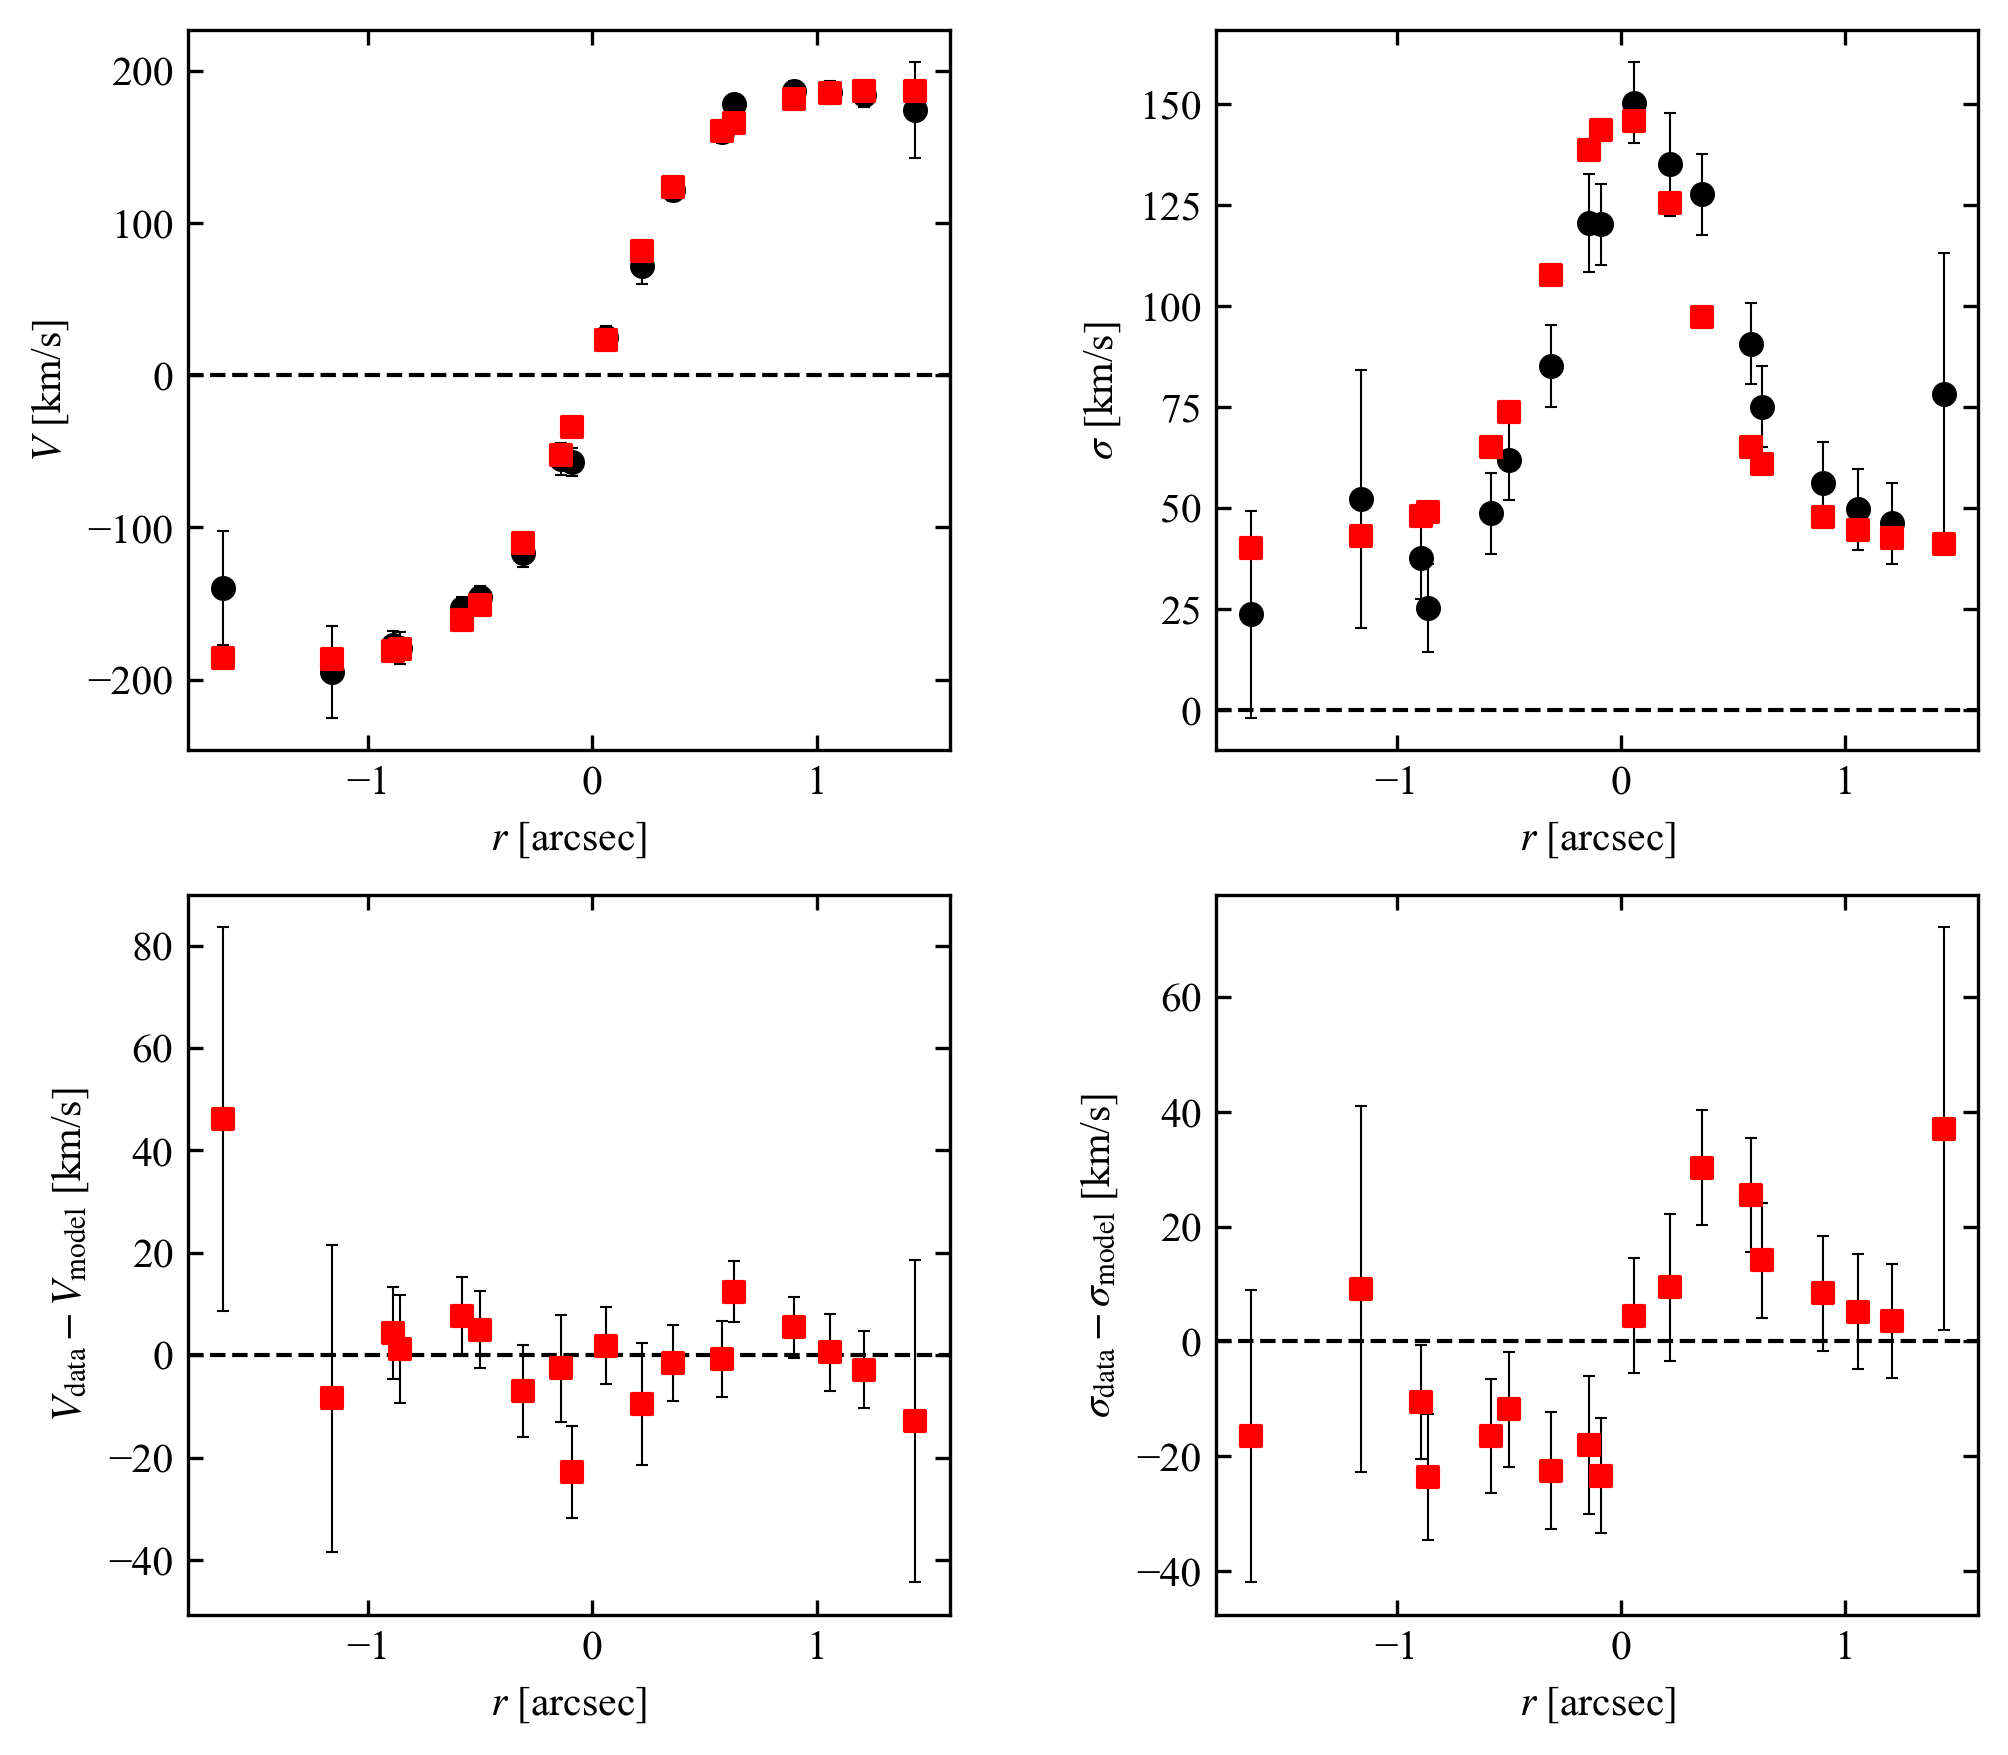

In [22]:
# Look at best-fit:
filepath = outdir_mpfit+"mpfit_best_fit.{}".format(plot_type)
Image(filename=filepath, width=600, height=570)

#### Reload the galaxy, results files:

In [23]:
f_galmodel =       outdir_mpfit + 'galaxy_model.pickle'
f_mpfit_results =  outdir_mpfit + 'mpfit_results.pickle'

gal, mpfit_results = fitting.reload_all_fitting_mpfit(filename_galmodel=f_galmodel, 
                            filename_results=f_mpfit_results)

#### Plot the best-fit results:

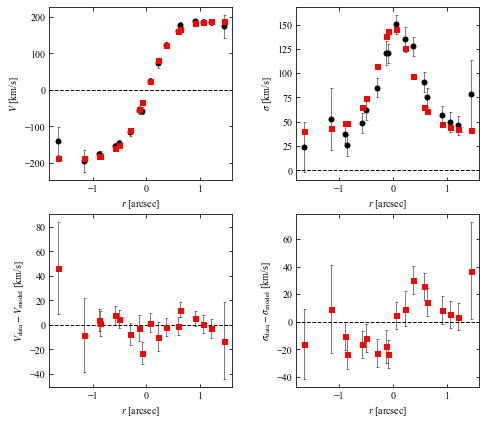

In [24]:
mpfit_results.plot_results(gal, fitdispersion=fitdispersion, 
                              oversample=oversample, 
                              f_plot_bestfit=None)

### Print results report:

In [25]:
# Print report
print(mpfit_results.results_report(gal=gal))

###############################
 Fitting for GS4_43501

Date: 2020-10-20 21:29:53.320902

Datafile: /Users/sedona/data/dysmalpy_example_data/GS4_43501.obs_prof.txt

Fitting method: MPFIT

profile1d_type: circ_ap_cube
moment_calc: False
partial_weight: True
pressure_support_type: 1

###############################
 Fitting results
-----------
 disk+bulge
    total_mass       10.6801  +/-   0.0401
    r_eff_disk        2.8897  +/-   0.3326

    n_disk            1.0000  [FIXED]
    r_eff_bulge       1.0000  [FIXED]
    n_bulge           4.0000  [FIXED]
    bt                0.3000  [FIXED]
-----------
 halo
    fdm               0.2832  +/-   0.0478

    mvirial          12.4925  [TIED]
    conc              5.0000  [FIXED]
-----------
 dispprof
    sigma0           38.6927  +/-   4.3020
-----------
 zheightgaus
    sigmaz            0.4909  [TIED]
-----------
 geom
    inc              62.0000  [FIXED]
    pa              142.0000  [FIXED]
    xshift            0.0000  [FIXED]
    yshif

### Or save results report to file:

In [26]:
# Save report to file:
f_mpfit_report = outdir_mpfit + 'mpfit_fit_report.txt'
mpfit_results.results_report(gal=gal, filename=f_mpfit_report)

-----------------

## MCMC Fitting

##### Get a clean copy of model, instrument

In [27]:
gal.model = copy.deepcopy(mod_set)
gal.instrument = copy.deepcopy(inst)

### MCMC fitting parameters ###

Set parameters for fitting: 
   - Passing options to `emcee`
   - Other calculation options

In [27]:
# Options passed to emcee
## SHORT TEST:
nwalkers = 20
ncpus = 4
scale_param_a = 3
nburn = 2
nsteps = 5
minaf = None
maxaf = None
neff = 10

# Other options
do_plotting = True       # Plot bestfit, corner, trace or not
oversample = 1           # Factor by which to oversample model (eg, subpixels)
fitdispersion = True     # Fit dispersion profile in addition to velocity

blob_name = 'mvirial'    # Also save 'blob' values of Mvirial, calculated at every chain step

outdir_mcmc = outdir + 'MCMC/'

# Choose plot filetype:
plot_type = 'png'

-------

### Run `Dysmalpy` fitting: MCMC

In [30]:
mcmc_results = fitting.fit(gal, nWalkers=nwalkers, nCPUs=ncpus,
                               scale_param_a=scale_param_a, nBurn=nburn,
                               nSteps=nsteps, minAF=minaf, maxAF=maxaf,
                               nEff=neff, do_plotting=do_plotting,
                               oversample=oversample, outdir=outdir_mcmc,
                               fitdispersion=fitdispersion,
                               profile1d_type=gal.data.profile1d_type,
                               blob_name=blob_name, 
                               plot_type=plot_type, overwrite=True)

INFO:DysmalPy:*************************************
INFO:DysmalPy: Fitting: GS4_43501 with MCMC
INFO:DysmalPy:    velocity file: /Users/sedona/data/dysmalpy_example_data/GS4_43501.obs_prof.txt
INFO:DysmalPy:
nCPUs: 4
INFO:DysmalPy:nWalkers: 20
INFO:DysmalPy:lnlike: red_chisq=False
INFO:DysmalPy:lnlike: oversampled_chisq=True
INFO:DysmalPy:
blobs: mvirial
INFO:DysmalPy:
mvirial_tied: <function tie_lmvirial_NFW at 0x1a1d2b1950>
INFO:DysmalPy:nSubpixels: 1
INFO:DysmalPy:
Burn-in:
Start: 2020-10-20 21:29:53.579597

INFO:DysmalPy: k=0, time.time=2020-10-20 21:29:53.582097, a_frac=nan
INFO:DysmalPy: k=1, time.time=2020-10-20 21:30:00.159755, a_frac=0.25
INFO:DysmalPy:
End: 2020-10-20 21:30:02.818279

******************
nCPU, nParam, nWalker, nBurn = 4, 4, 20, 2
Scale param a= 3
Time= 9.24 (sec),   0:9.24 (m:s)
Mean acceptance fraction: 0.325
Ideal acceptance frac: 0.2 - 0.5
Autocorr est: Undefined, chain did not converge
******************
INFO:DysmalPy:
#################
acorr time undefine

### Examine MCMC results

Of course this (very short!) example looks terrible, but it's instructive to see what's happening even if you only did a very short / few walker MCMC test:

### Trace
- The individual walkers should move around in the parameter space over the chain iterations (not necessarily for every step; but there should be ***some*** exploration of the space)

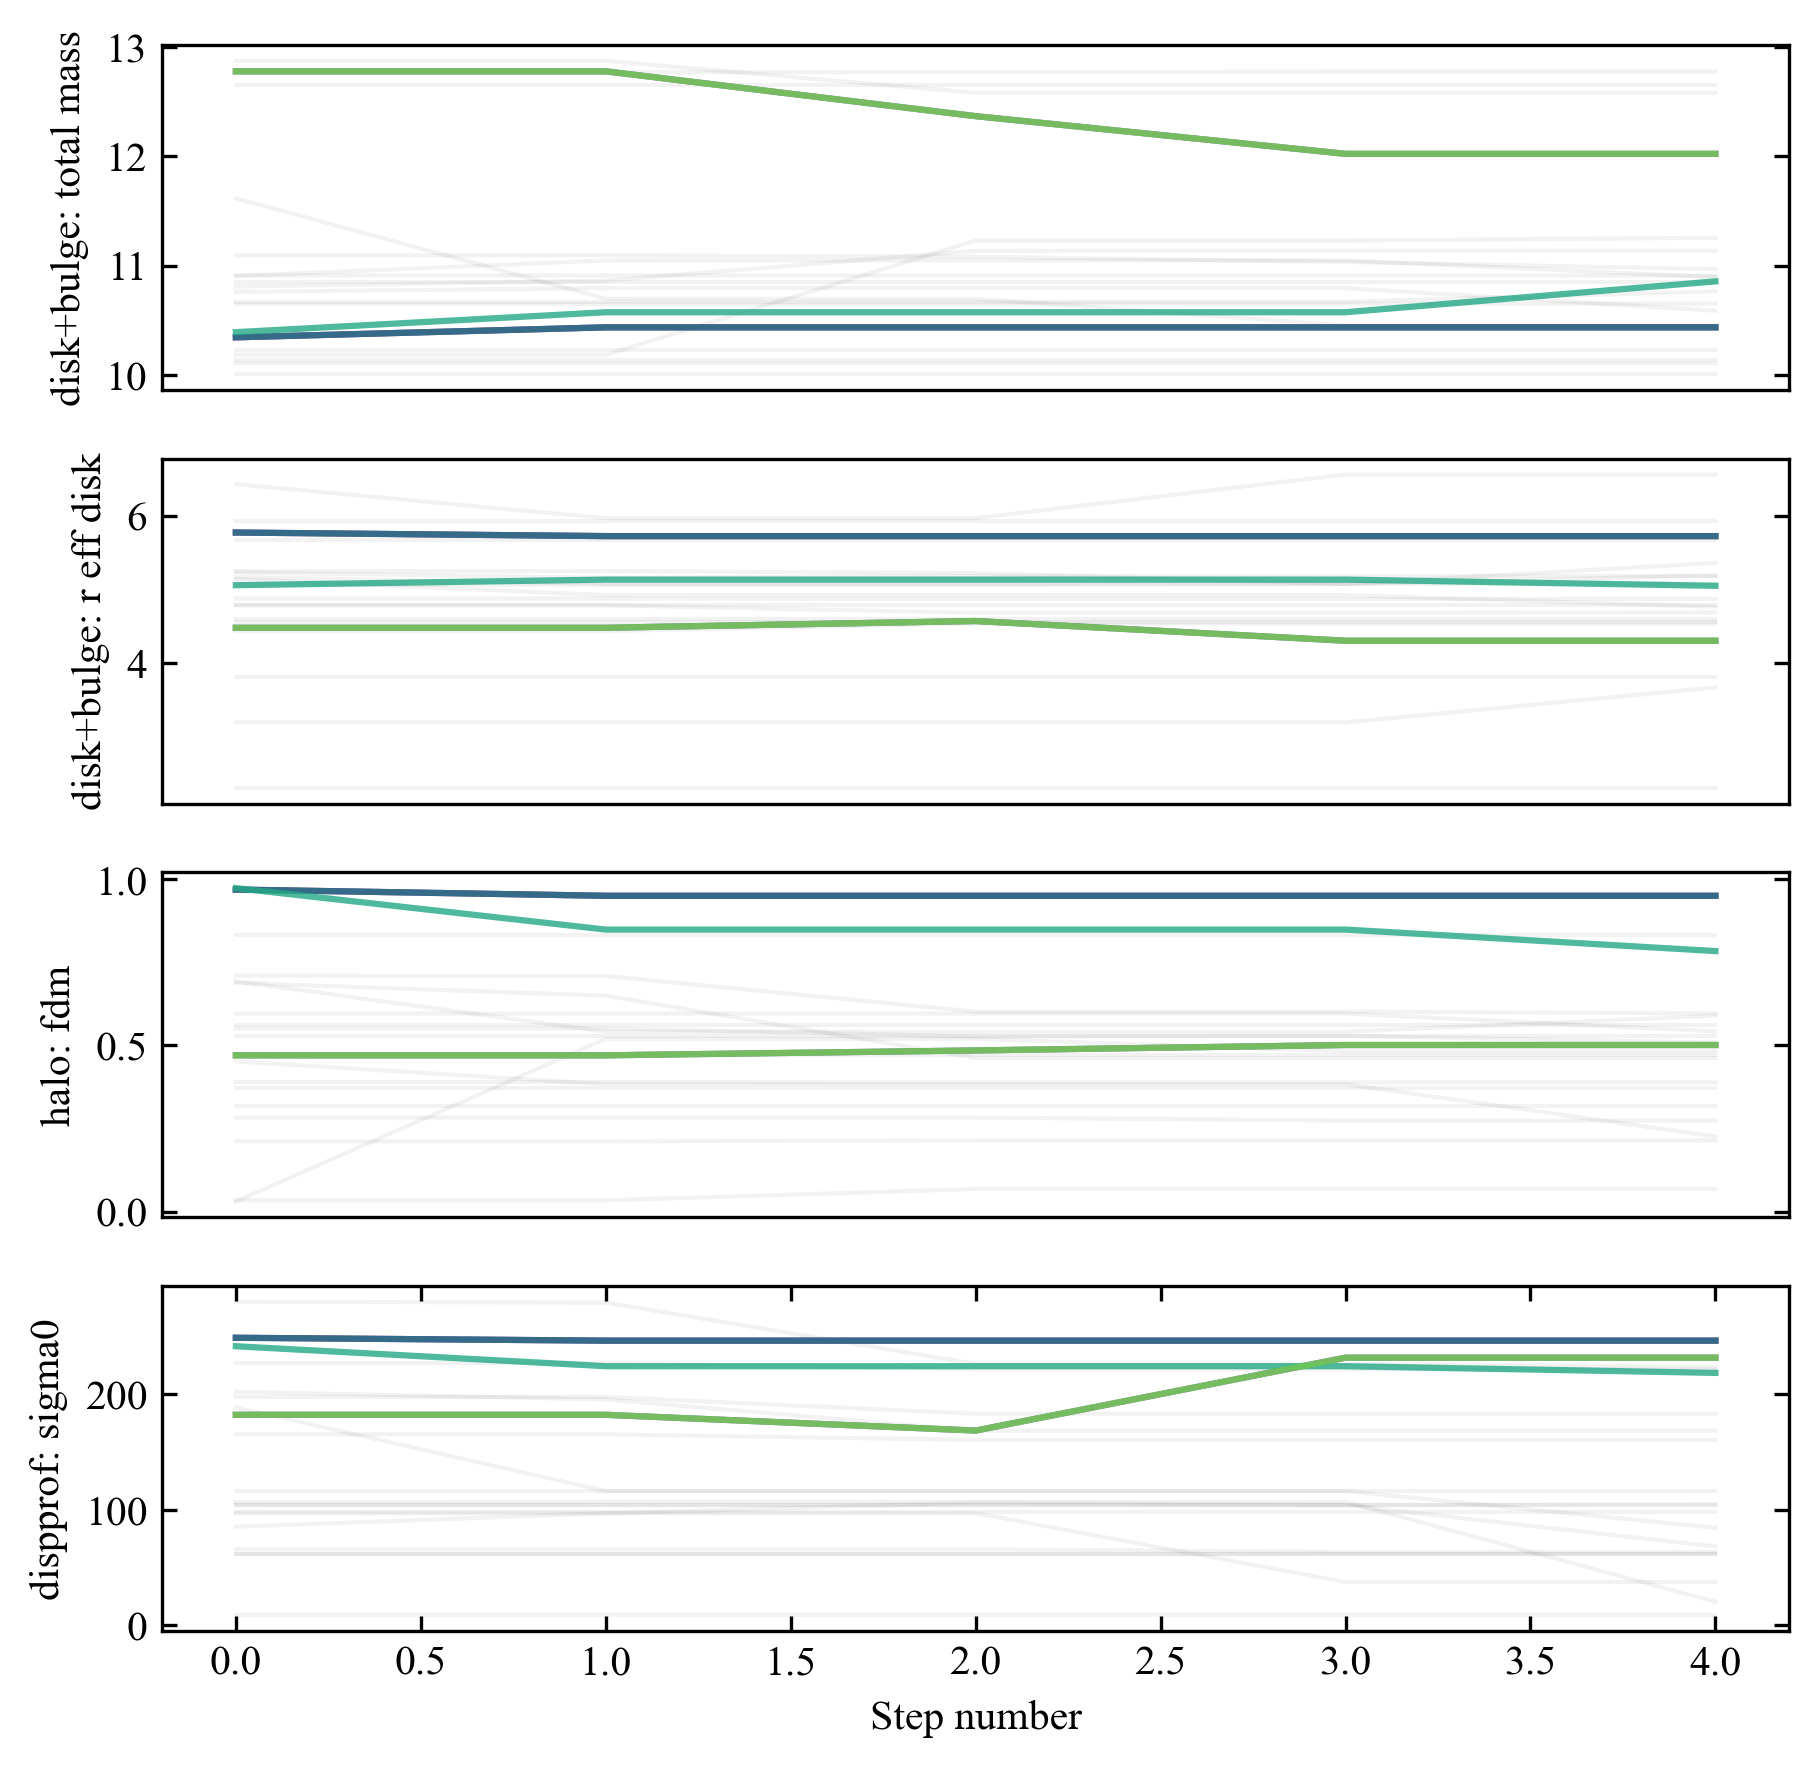

In [38]:
# Look at trace:
filepath = outdir_mcmc+"mcmc_trace.{}".format(plot_type)
Image(filepath, width=600, height=400)

### Best-fit
- This is a good opportunity to check that the model PA and slit PA are correct, or else the data and model curves will have opposite shapes!

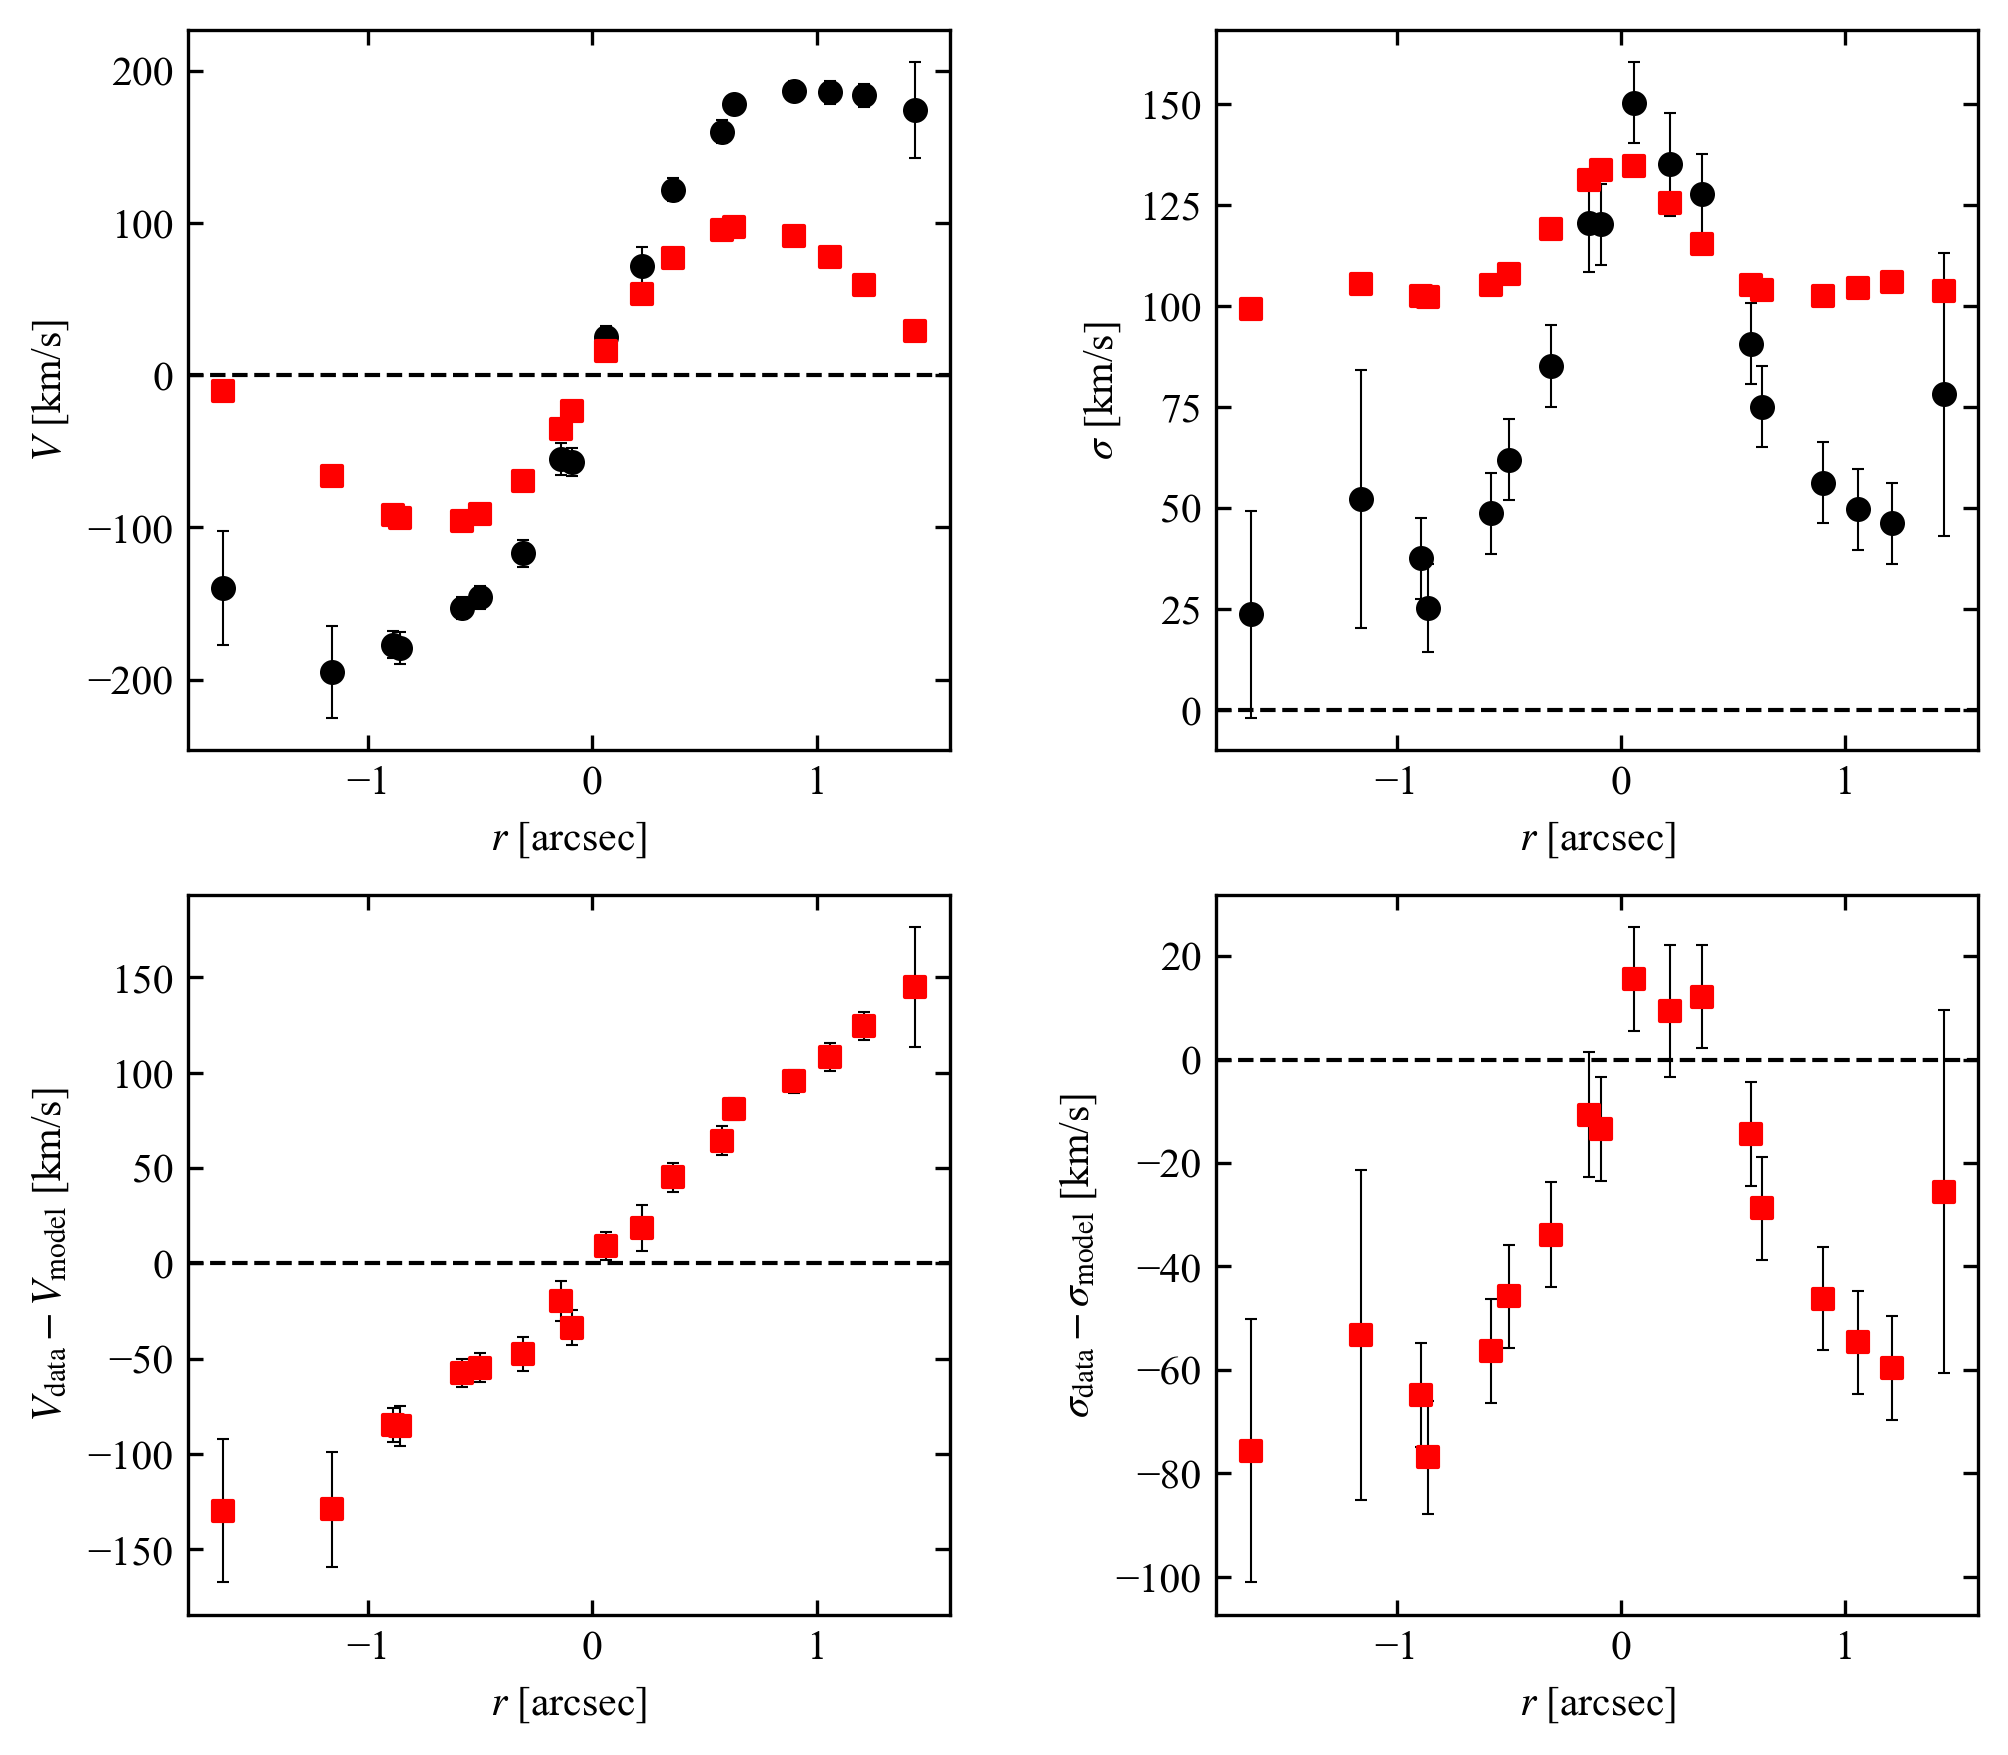

In [32]:
# Look at best-fit:
filepath = outdir_mcmc+"mcmc_best_fit.{}".format(plot_type)
Image(filepath, width=600, height=570)

### Sampler "corner" plot
- The "best-fit" MAP (by default taken to be the peak of each marginalized parameter posterior, independent of the other parameters) is marked with the solid blue line. 
  * However, the MAP can also be found by jointly analyzing two or more parameters' posterior space (see example below).
- Check to see that your Gaussian prior centers are marked in orange in the appropriate rows/columns (if any Gaussian priors are used).
- The vertical dashed black lines show the 2.275%, 15.865%, 84.135%, 97.725% percentile intervals for the marginalized posterior for each parameter. 
- The vertical dashed purple lines show the shortest $1\sigma$ interval, determined from the marginalized posterior for each parameter independently. 

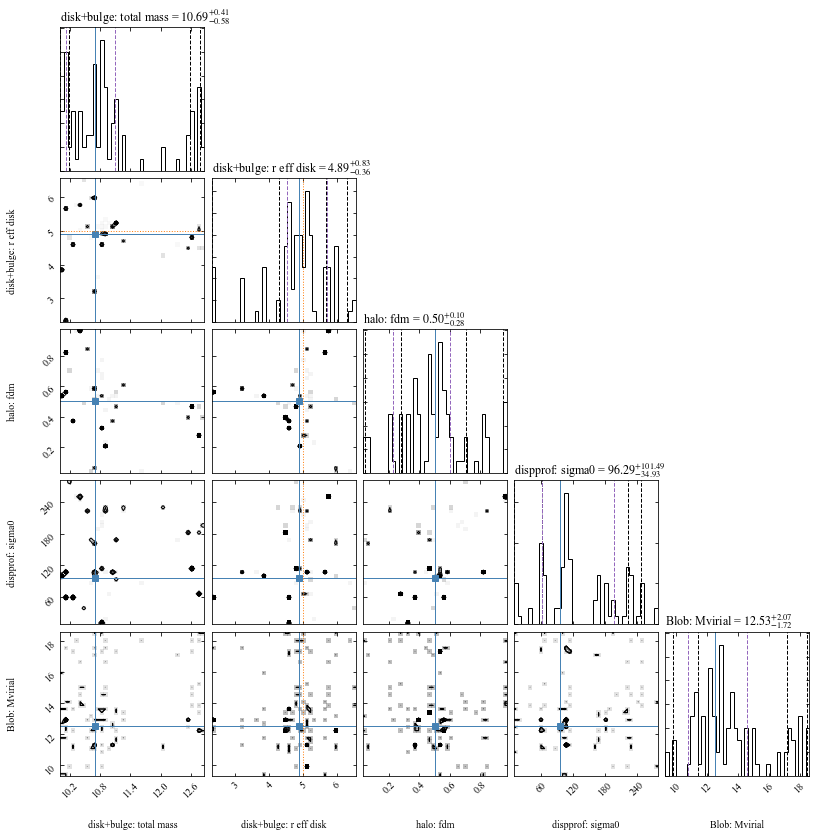

In [33]:
# Look at corner:
filepath = outdir_mcmc+"mcmc_param_corner.{}".format(plot_type)
Image(filepath, width=570, height=620)

---------

# Look at a real MCMC example:

In the interest of time, let's look at some results calculated previously.

For this fit, we used 1000 walkers, 50 burn-in steps, and 200 steps. 

Using **190 threads**, it took about **25 minutes** to run the MCMC fit.

In [28]:
outdir_mcmc_full = outdir + 'MCMC_full_run_nw1000_ns200/'

## Load and examine results: ##

Helpful for:
  - replotting
  - reanalyzing chain (eg, jointly constraining some posteriors)
  - ...

#### Reload the galaxy, results files:

In [29]:
f_galmodel =      outdir_mcmc_full + 'galaxy_model.pickle'
f_mcmc_results =  outdir_mcmc_full + 'mcmc_results.pickle'

gal, mcmc_results = fitting.reload_all_fitting(filename_galmodel=f_galmodel, 
                            filename_mcmc_results=f_mcmc_results)

# # Fix some references to tied functions (not necessary if same code on both machines)
# sys.modules['tie_sigz_reff'] = tie_sigz_reff
# sys.modules['tie_lmvirial_NFW'] = tie_lmvirial_NFW

#### If necessary, also reload the sampler chain:

In [30]:
f_sampler =  outdir_mcmc_full + 'mcmc_sampler.{}'.format(ftype_sampler)
mcmc_results.reload_sampler(filename=f_sampler)

#### Plot the best-fit results:

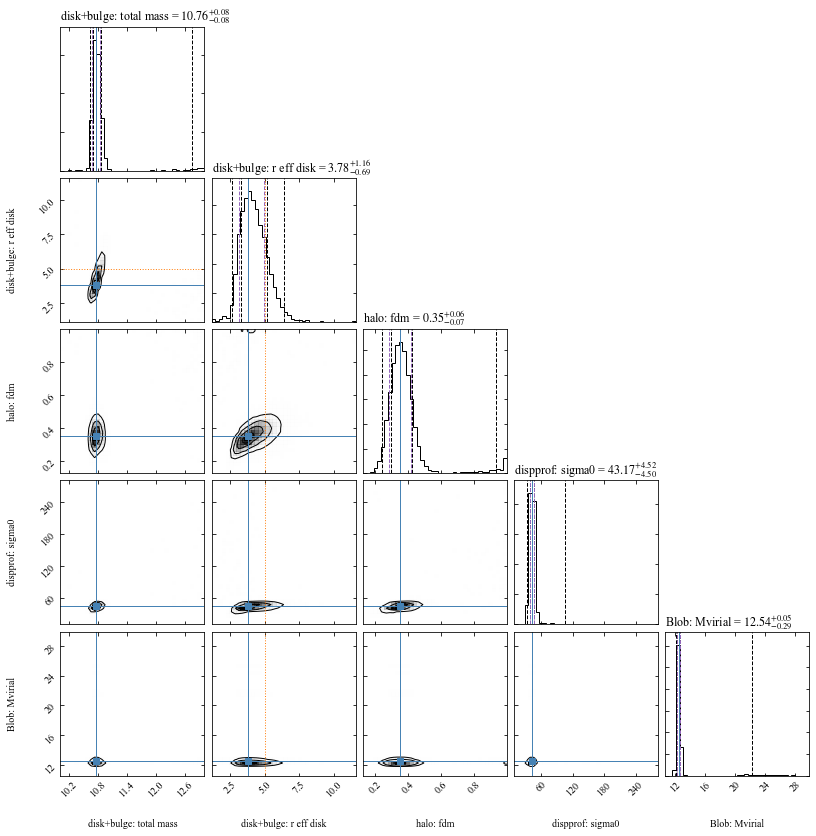

SystemError: unknown opcode

In [31]:
mcmc_results.plot_results(gal, fitdispersion=fitdispersion, 
                          oversample=oversample, 
                          f_plot_param_corner=None, 
                          f_plot_bestfit=None, f_plot_trace=None)

In [58]:
%debug

> /Users/sedona/software_public/dysmalpy/examples/notebooks/dysmalpy_example_fit_1D.py(76)tie_lmvirial_NFW()

ipdb> exit


### Print results report:

In [37]:
# Print report
print(mcmc_results.results_report(gal=gal))

###############################
 Fitting for GS4_43501

Date: 2020-10-20 21:20:19.229861

Datafile: /Users/sedona/data/dysmalpy_example_data/GS4_43501.obs_prof.txt

Fitting method: MCMC

profile1d_type: circ_ap_cube
moment_calc: False
partial_weight: True
pressure_support_type: 1

###############################
 Fitting results
-----------
 disk+bulge
    total_mass       11.0908  -   0.4683 +   0.6660
    r_eff_disk        4.5370  -   0.1630 +   0.7938

    n_disk            1.0000  [FIXED]
    r_eff_bulge       1.0000  [FIXED]
    n_bulge           4.0000  [FIXED]
    bt                0.3000  [FIXED]
-----------
 halo
    fdm               0.4918  -   0.1096 +   0.1763

    mvirial          13.7288  [TIED]
    conc              5.0000  [FIXED]
-----------
 dispprof
    sigma0           90.7989  -  17.1379 + 107.2376
-----------
 zheightgaus
    sigmaz            0.7707  [TIED]
-----------
 geom
    inc              62.0000  [FIXED]
    pa              142.0000  [FIXED]
    xshift  

### Or save results report to file:

In [38]:
# Save report to file:
f_mcmc_report = outdir_mcmc + 'mcmc_fit_report.txt'
mcmc_results.results_report(gal=gal, filename=f_mcmc_report)

-------------

### *Option*: 

#### Reanalyze sampler for MAP using joint posterior spaces for some parameters

In [39]:
# Look at joint posterior of 4 parameters simultaneously:
#       total baryonic mass, r_eff_disk, fDM, sigma0

# Create a list / an array containing each parameter to include:
linked_post_arr = []
# For each parameter, include a length 2 list / array 
#     with the component name and parameter name:
linked_post_arr.append(['disk+bulge', 'total_mass'])
linked_post_arr.append(['disk+bulge', 'r_eff_disk'])
linked_post_arr.append(['halo', 'fdm'])
linked_post_arr.append(['dispprof', 'sigma0'])


# Only consider 1 bundle of joint posteriors:
linked_posterior_names = [ linked_post_arr ]

In [40]:
# Then rerun the posterior distribution analysis, using this linked posterior set:
mcmc_results.analyze_posterior_dist(gal=gal, 
                    linked_posterior_names=linked_posterior_names)

In [41]:
# Update theta to best-fit:
gal.model.update_parameters(mcmc_results.bestfit_parameters)

In [42]:
# Recalculate the bestfit chisq / redchisq:
gal.create_model_data(oversample=oversample, 
                      line_center=gal.model.line_center, 
                      profile1d_type=gal.data.profile1d_type)

mcmc_results.bestfit_redchisq = fitting.chisq_red(gal, fitdispersion=fitdispersion)
mcmc_results.bestfit_chisq = fitting.chisq_eval(gal, fitdispersion=fitdispersion)

#### Print the report for this re-analysis:

In [43]:
# Print report
print(mcmc_results.results_report(gal=gal))

###############################
 Fitting for GS4_43501

Date: 2020-10-20 21:20:19.917429

Datafile: /Users/sedona/data/dysmalpy_example_data/GS4_43501.obs_prof.txt

Fitting method: MCMC

profile1d_type: circ_ap_cube
moment_calc: False
partial_weight: True
pressure_support_type: 1

###############################
 Fitting results
-----------
 disk+bulge
    total_mass       10.7738  -   0.1513 +   0.9830
    r_eff_disk        4.5033  -   0.1293 +   0.8276

    n_disk            1.0000  [FIXED]
    r_eff_bulge       1.0000  [FIXED]
    n_bulge           4.0000  [FIXED]
    bt                0.3000  [FIXED]
-----------
 halo
    fdm               0.5981  -   0.2158 +   0.0701

    mvirial          13.3825  [TIED]
    conc              5.0000  [FIXED]
-----------
 dispprof
    sigma0           84.5658  -  10.9048 + 113.4707
-----------
 zheightgaus
    sigmaz            0.7649  [TIED]
-----------
 geom
    inc              62.0000  [FIXED]
    pa              142.0000  [FIXED]
    xshift  

#### Plot the best-fit results:

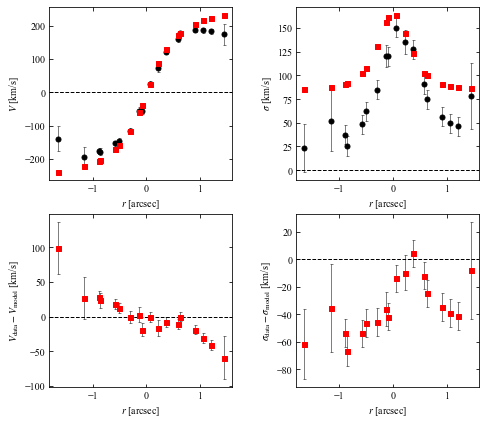

In [44]:
mcmc_results.plot_bestfit(gal, fitdispersion=fitdispersion, 
                         oversample=oversample)

#### Plot the posterior distribution showing this new joint-posterior MAP:

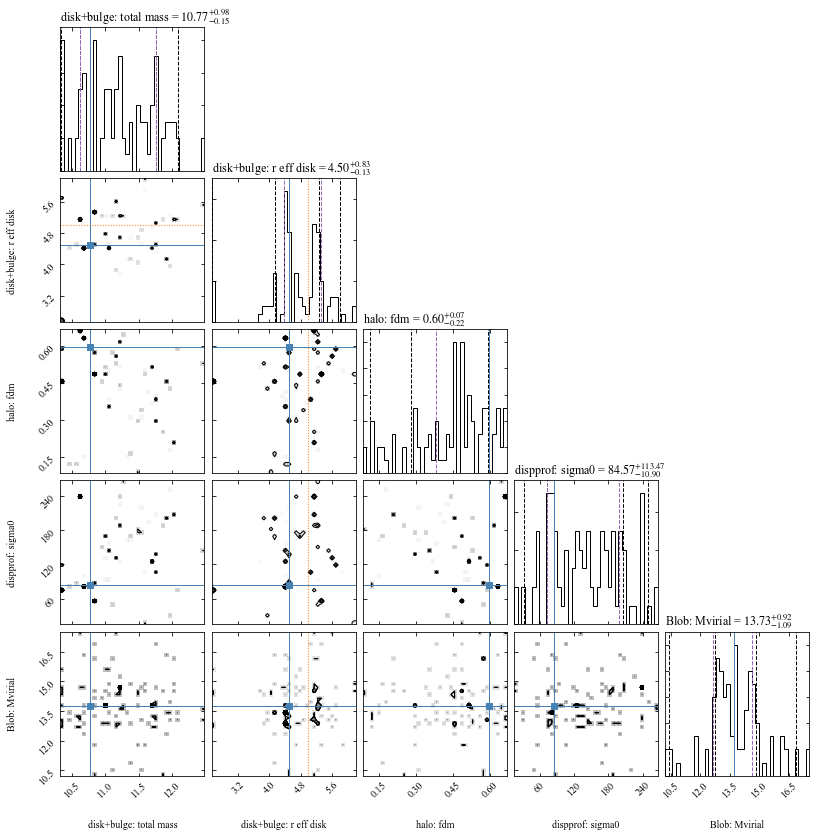

In [45]:
mcmc_results.plot_corner(gal)

------